Using device: cpu
Loading model...
Loading data...
Loading metadata and scalers...
1. Computing reconstruction error...


Computing reconstruction errors: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [48:33<00:00,  2.91s/it]



--- Reconstruction Error Report (RMSE) ---
                    Mean RMSE  Std Dev RMSE  Samples
Mode                                                
BIKE                 3.956243      1.407767       44
BUS                  5.499136      3.392395       48
ELECT_BIKE           4.319993      1.196113       28
ELECT_SCOOTER        3.767880      1.116513       10
OTHER                1.308110      0.553986        2
PRIV_CAR_DRIVER      7.928755      2.952279      294
PRIV_CAR_PASSENGER   7.164442      3.440293       46
SUBWAY               2.349575      2.081532       49
TAXI                 8.651505      1.329074        3
TRAIN                7.728107      4.697748       35
TRAMWAY              5.670781      1.787780       13
TWO_WHEELER          8.439734      1.951773        9
WALKING              1.778026      1.896137      301
mixed                6.912970      4.400228      118


2. Visualizing reconstruction examples...


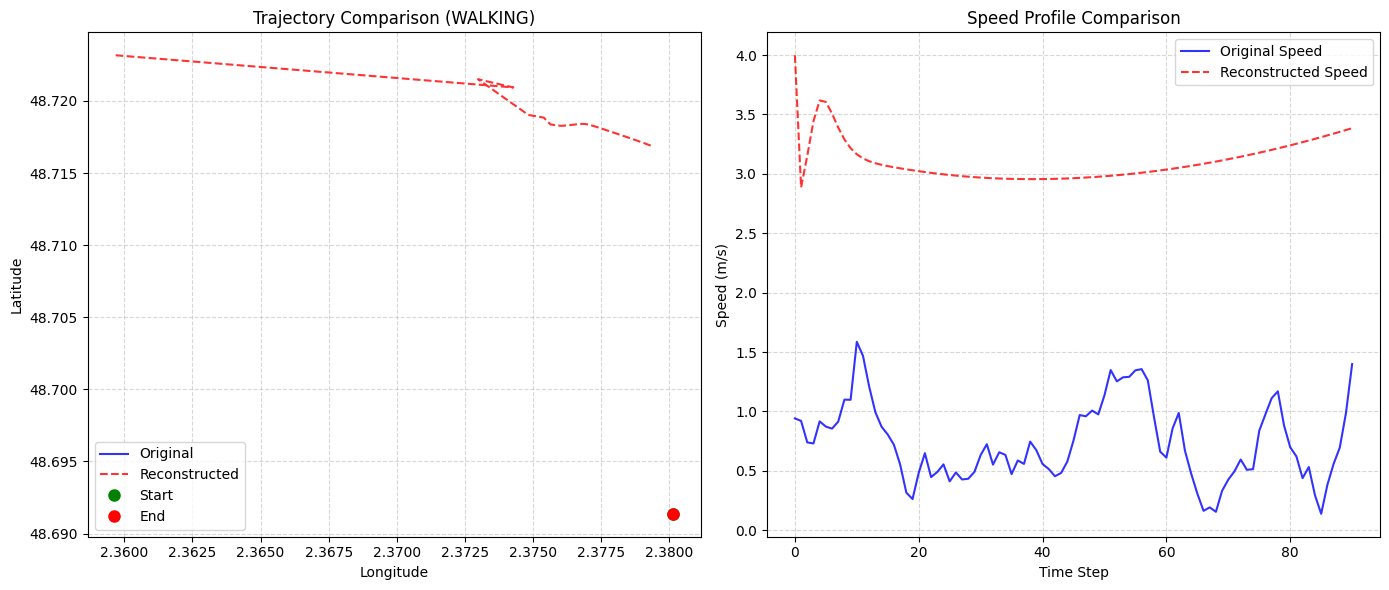

In [2]:
# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import pickle
from typing import Dict, List, Union, Tuple
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
import sys
sys.path.append('../..')

from ml_mobility_ns3.models.vae import ConditionalTrajectoryVAE
from ml_mobility_ns3.utils.model_utils import load_model_from_checkpoint

# %% Configuration
MODEL_PATH = Path("../results/efficient_run/best_model.pt")
DATA_PATH = Path("../preprocessing/vae_dataset.npz")
PREPROCESSING_DIR = Path("../preprocessing/")

# --- Device setup ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# %% Load Model and Data
def load_vae_model_and_data(model_path, data_path, preprocessing_dir):
    """Load model, data, and all necessary components."""
    print("Loading model...")
    model, config = load_model_from_checkpoint(model_path, device)
    
    print("Loading data...")
    data = np.load(data_path)
    
    print("Loading metadata and scalers...")
    with open(preprocessing_dir / "metadata.pkl", 'rb') as f:
        metadata = pickle.load(f)
    
    with open(preprocessing_dir / "scalers.pkl", 'rb') as f:
        scalers = pickle.load(f)
    
    return model, data, metadata, scalers

model, data, metadata, scalers = load_vae_model_and_data(MODEL_PATH, DATA_PATH, PREPROCESSING_DIR)
idx_to_mode = {i: name for i, name in enumerate(metadata['transport_modes'])}

# %% Trajectory Reconstruction Function
def reconstruct_trajectory(
    model: ConditionalTrajectoryVAE,
    data: Dict[str, np.ndarray],
    index: int
) -> Dict[str, Union[np.ndarray, str, int]]:
    """Reconstruct a single trajectory from the dataset."""
    # Get original data
    traj = torch.tensor(data['trajectories'][index:index+1], dtype=torch.float32, device=device)
    mask = torch.tensor(data['masks'][index:index+1], dtype=torch.bool, device=device)
    mode = torch.tensor([data['transport_modes'][index]], dtype=torch.long, device=device)
    length = torch.tensor([data['trip_lengths'][index]], dtype=torch.long, device=device)
    
    # Reconstruct
    with torch.no_grad():
        recon, _, _ = model(traj, mode, length, mask)
        
    # Process results
    valid_length = int(length.item())
    trajectory_scaler = scalers['trajectory']
    
    original_scaled = traj[0, :valid_length].cpu().numpy()
    recon_scaled = recon[0, :valid_length].cpu().numpy()
    
    return {
        'original': trajectory_scaler.inverse_transform(original_scaled),
        'reconstructed': trajectory_scaler.inverse_transform(recon_scaled),
        'mode': idx_to_mode[data['transport_modes'][index]],
        'length': valid_length
    }

# %% Error Computation Function
def compute_reconstruction_error(
    model: ConditionalTrajectoryVAE,
    data: Dict[str, np.ndarray],
    n_samples: int = 500
) -> pd.DataFrame:
    """Compute reconstruction errors (RMSE) across a sample of the dataset."""
    n_total = len(data['trajectories'])
    indices = np.random.choice(n_total, min(n_samples, n_total), replace=False)
    
    errors_by_mode = {mode: [] for mode in metadata['transport_modes']}
    
    for idx in tqdm(indices, desc="Computing reconstruction errors"):
        recon_result = reconstruct_trajectory(model, data, idx)
        
        # RMSE on unscaled latitude, longitude, and speed
        error = np.sqrt(mean_squared_error(
            recon_result['original'], 
            recon_result['reconstructed']
        ))
        errors_by_mode[recon_result['mode']].append(error)
        
    # Compile results
    results = []
    for mode, errors in errors_by_mode.items():
        if errors:
            results.append({
                'Mode': mode,
                'Mean RMSE': np.mean(errors),
                'Std Dev RMSE': np.std(errors),
                'Samples': len(errors)
            })
            
    return pd.DataFrame(results).set_index('Mode')

# %% Visualization Function
def plot_reconstruction_comparison(
    recon_result: Dict, 
    figsize: Tuple[int, int] = (14, 6)
):
    """Plot original vs. reconstructed trajectory and their speed profiles."""
    fig, (ax_map, ax_speed) = plt.subplots(1, 2, figsize=figsize)
    
    orig = recon_result['original']
    recon = recon_result['reconstructed']
    
    # --- Map Plot ---
    ax_map.plot(orig[:, 1], orig[:, 0], 'b-', label='Original', alpha=0.8)
    ax_map.plot(recon[:, 1], recon[:, 0], 'r--', label='Reconstructed', alpha=0.8)
    ax_map.plot(orig[0, 1], orig[0, 0], 'go', markersize=8, label='Start')
    ax_map.plot(orig[-1, 1], orig[-1, 0], 'ro', markersize=8, label='End')
    ax_map.set_title(f"Trajectory Comparison ({recon_result['mode']})")
    ax_map.set_xlabel('Longitude')
    ax_map.set_ylabel('Latitude')
    ax_map.legend()
    ax_map.grid(True, linestyle='--', alpha=0.5)
    
    # --- Speed Profile Plot ---
    time_axis = np.arange(recon_result['length'])
    ax_speed.plot(time_axis, orig[:, 2], 'b-', label='Original Speed', alpha=0.8)
    ax_speed.plot(time_axis, recon[:, 2], 'r--', label='Reconstructed Speed', alpha=0.8)
    ax_speed.set_title("Speed Profile Comparison")
    ax_speed.set_xlabel('Time Step')
    ax_speed.set_ylabel('Speed (m/s)')
    ax_speed.legend()
    ax_speed.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


# %% --- Main Execution ---
# 1. Compute reconstruction error
print("1. Computing reconstruction error...")
error_report = compute_reconstruction_error(model, data, n_samples=1000)
print("\n--- Reconstruction Error Report (RMSE) ---")
print(error_report)

# 2. Visualize some examples
print("\n\n2. Visualizing reconstruction examples...")
# You can change this index to see different reconstructions
sample_index_to_visualize = 42 
reconstruction_sample = reconstruct_trajectory(model, data, sample_index_to_visualize)

plot_reconstruction_comparison(reconstruction_sample)

# You can loop to find an interesting example for another mode
for i in range(len(data['transport_modes'])):
    if idx_to_mode[data['transport_modes'][i]] == 'WALK':
        walk_sample = reconstruct_trajectory(model, data, i)
        plot_reconstruction_comparison(walk_sample)
        break # Just show the first one we find